⚙️ Inicializando ambiente de Alta Performance...

📌 CARREGAMENTO DE DADOS
   Por favor, envie o arquivo do IDEB (.xlsx ou .csv)



Saving divulgacao_ensino_medio_escolas_2023.xlsx to divulgacao_ensino_medio_escolas_2023 (2).xlsx
✅ Base processada com sucesso!
📊 Escolas Analisadas: 276




📌 1. DIAGNÓSTICO ESTADUAL
   Como as notas estão distribuídas hoje?

📢 ROTEIRO DE FALA: 'Este gráfico mostra a frequência das notas. A linha vermelha é a nossa média atual.'



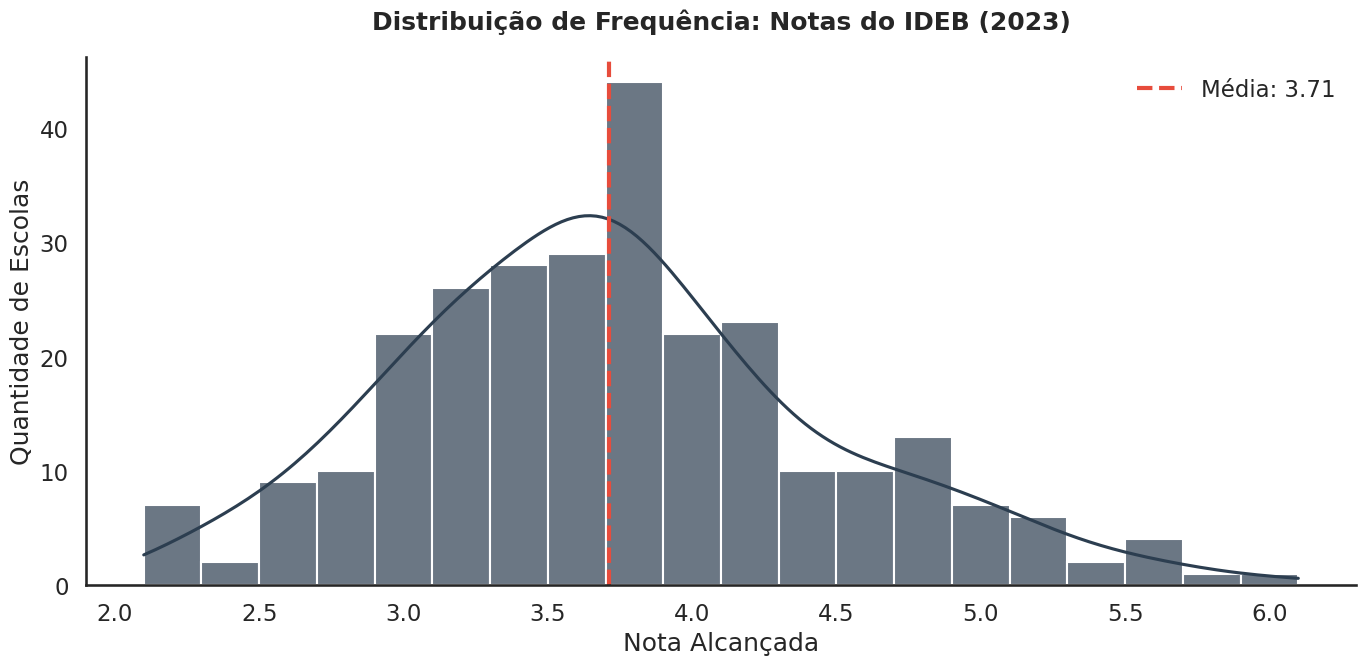






📌 2. COMPARATIVO POR REDE
   Quem está entregando mais resultado?

📢 ROTEIRO DE FALA: 'Aqui comparamos a consistência. Caixas mais altas indicam melhores resultados gerais.'



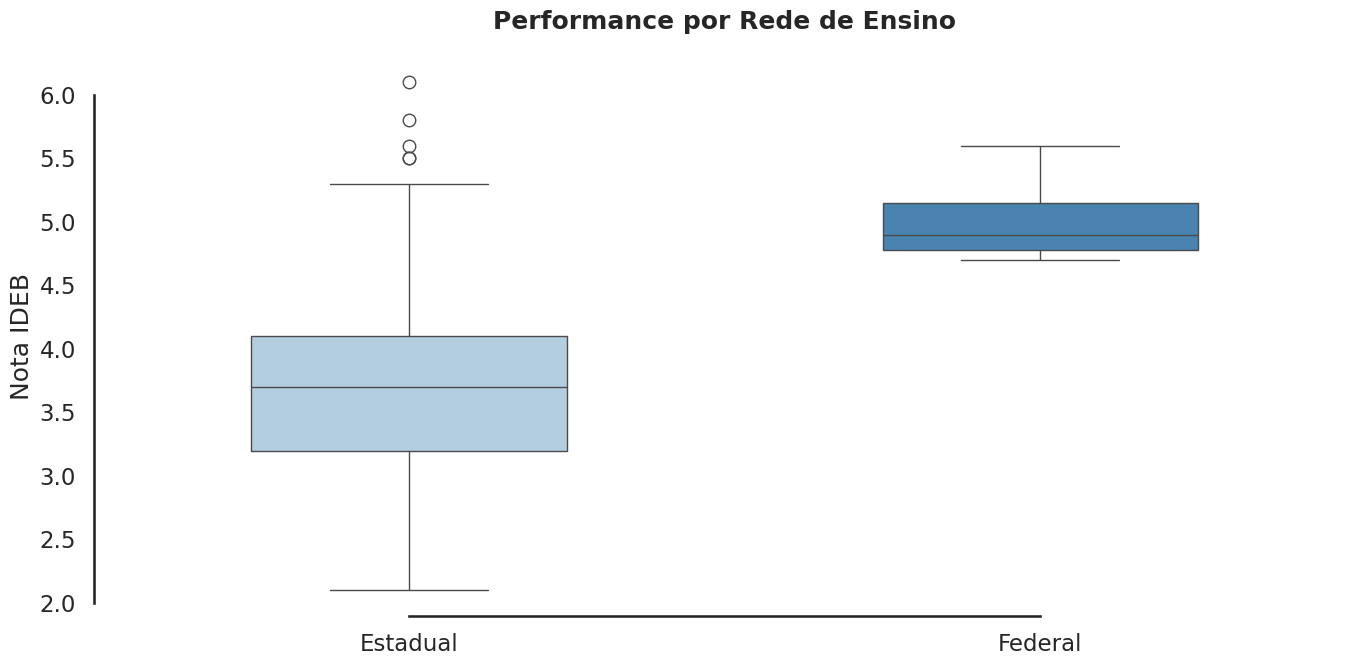






📌 3. O MOTOR DA NOTA
   O que impacta mais: Aprovação ou Matemática?



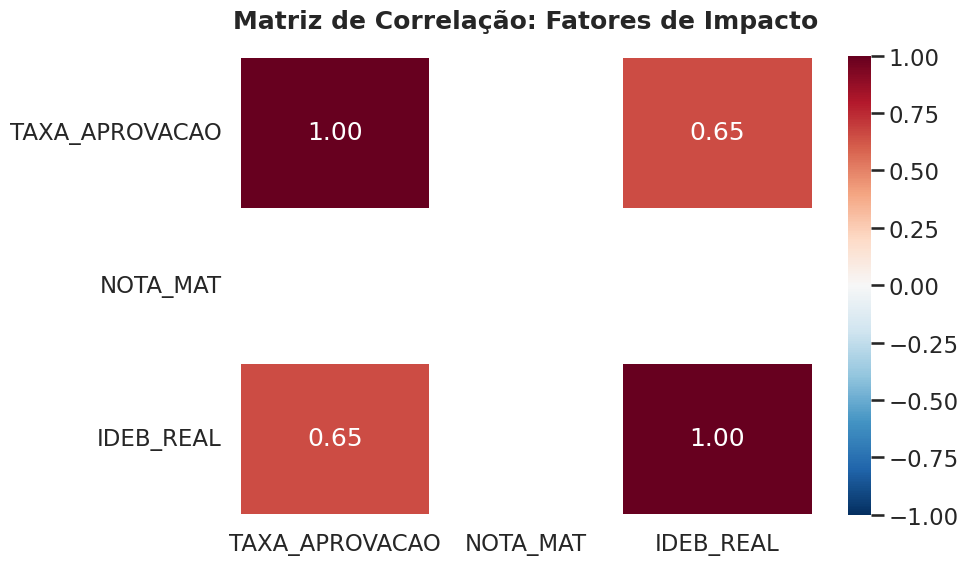


💡 INSIGHT: Números próximos de 1.0 indicam forte influência positiva.




🔄 Processando Modelos de IA (Aguarde alguns segundos)...

📌 4. MAPA ESTRATÉGICO DAS ESCOLAS
   Segmentação via K-Means Clustering

📢 ROTEIRO DE FALA: 'Cada ponto é uma escola. A IA as agrupou por similaridade de comportamento.'



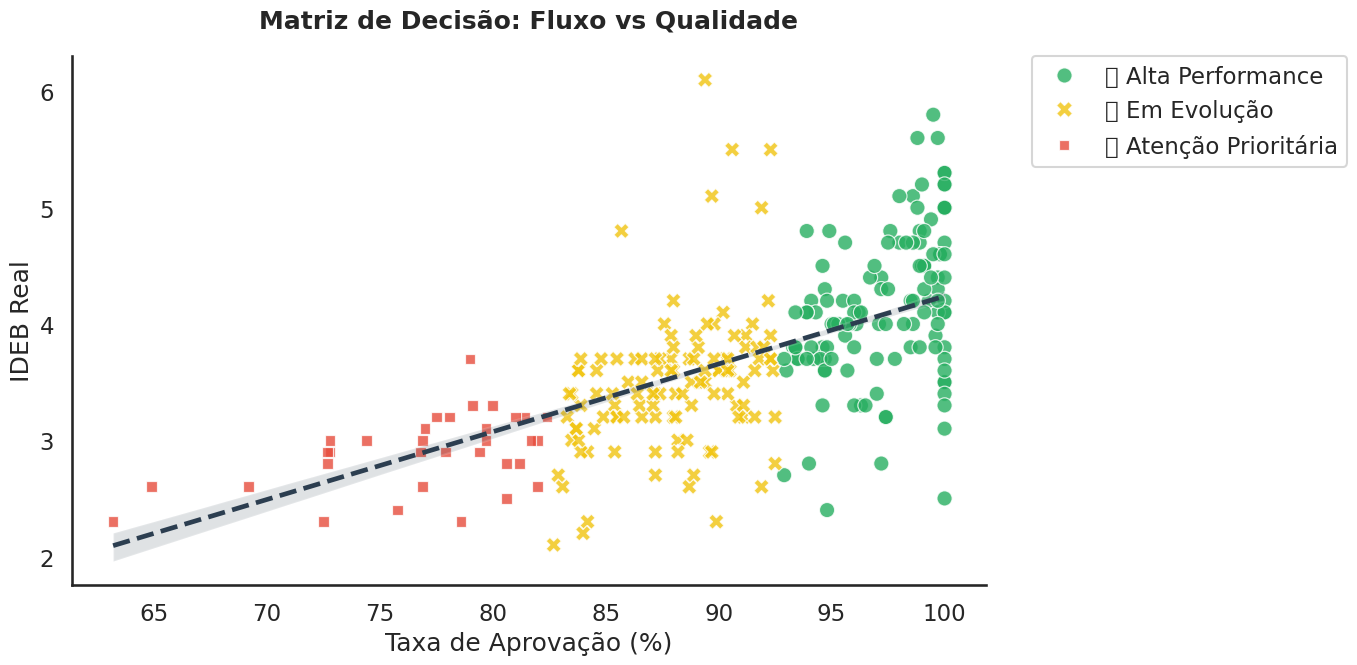






📌 5. O QUE A IA APRENDEU?
   Feature Importance (XGBoost)



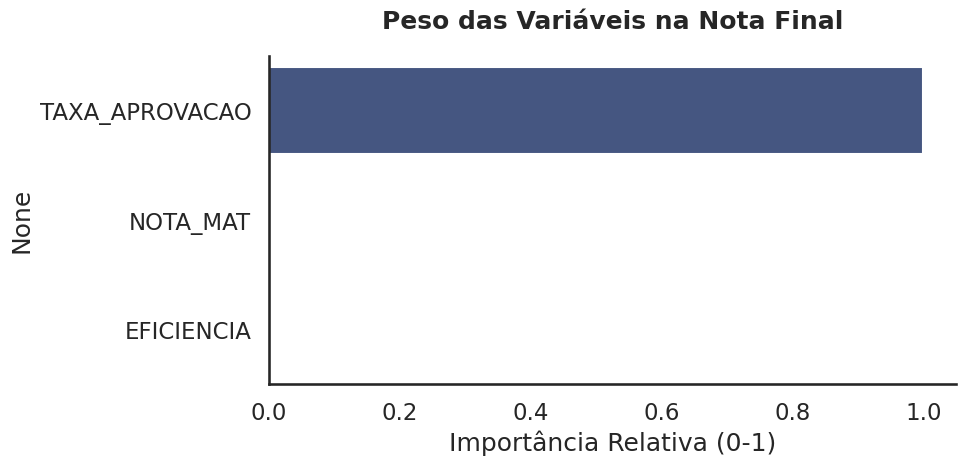






📌 6. DESTAQUES DE GESTÃO
   Escolas que superaram a expectativa da IA



,CÓDIGO DO MUNICÍPIO,NOME DA ESCOLA,IDEB_REAL,PREDICAO,SUPERACAO
370,1300631.000000,ESCOLA ESTADUAL EUCLIDES CORREA VIEIRA,6.100000,3.94,2.16
522,1302603.000000,COLEGIO MILITAR DA POLICIA MILITAR DO AMAZONAS,5.500000,3.76,1.74
473,1302108.000000,ESCOLA ESTADUAL RAIMUNDO ROBERTO,5.500000,3.96,1.54
472,1302108.000000,ESCOLA ESTADUAL DOROTHEA DE SOUZA BRAGA,5.100000,3.68,1.42
656,1302603.000000,EETI MARCANTONIO VILACA II,5.800000,4.49,1.31







📌 7. FUTURO: 2024 E 2025
   Tendência baseada no histórico



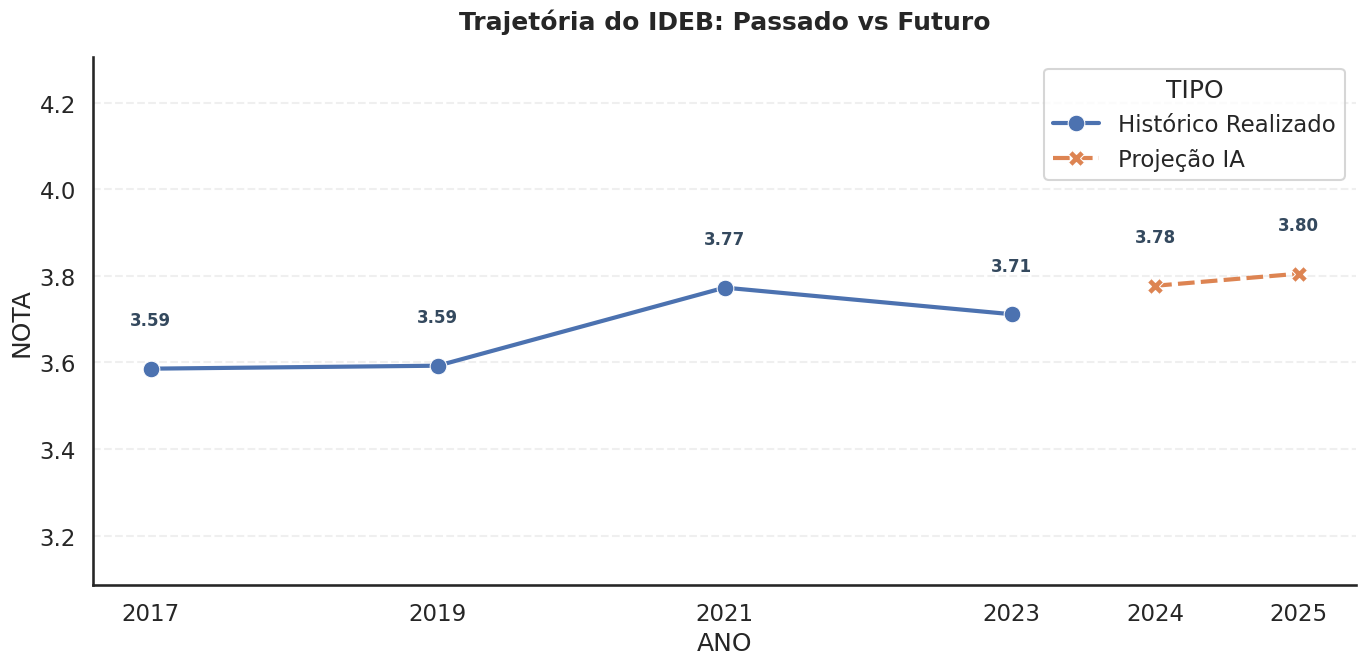


📌 FIM DA APRESENTAÇÃO
   Análise gerada via Python/XGBoost



In [3]:
# ==============================================================================
# 📊 SISTEMA DE ANÁLISE EDUCACIONAL E PREDITIVA (IDEB - AM)
# ==============================================================================
# Autor: Equipe de Dados
# Versão: 2.0 (Design Profissional & Espaçamento Otimizado)

# --- 1. SETUP INICIAL ---
print("⚙️ Inicializando ambiente de Alta Performance...")
!pip install xgboost -q

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from google.colab import files
import io
from IPython.display import display, Markdown

# --- CONFIGURAÇÃO DE DESIGN (ESTILO EXECUTIVO) ---
sns.set_theme(style="white", context="talk") # Fundo branco, fontes maiores
plt.rcParams['figure.figsize'] = (14, 7)     # Gráficos largos
plt.rcParams['axes.titlesize'] = 18          # Títulos bem visíveis
plt.rcParams['axes.titleweight'] = 'bold'    # Títulos em negrito
plt.rcParams['axes.titlepad'] = 20           # Espaço entre título e gráfico
plt.rcParams['font.family'] = 'sans-serif'   # Fonte moderna

def print_header(titulo, subtitulo=""):
    """Cria um cabeçalho formatado para separar as seções"""
    print("\n" + "="*80)
    print(f"📌 {titulo.upper()}")
    if subtitulo:
        print(f"   {subtitulo}")
    print("="*80 + "\n")

# ==============================================================================
# 📂 2. INGESTÃO DE DADOS
# ==============================================================================
print_header("CARREGAMENTO DE DADOS", "Por favor, envie o arquivo do IDEB (.xlsx ou .csv)")

uploaded = files.upload()

if len(uploaded) == 0:
    print("❌ Operação cancelada pelo usuário.")
else:
    file_name = next(iter(uploaded))
    io_file = io.BytesIO(uploaded[file_name])

    # Função Robustez de Leitura
    def carregar_base(file_obj, is_excel):
        try:
            if is_excel: df_temp = pd.read_excel(file_obj, header=None, nrows=30)
            else:
                try: df_temp = pd.read_csv(file_obj, header=None, nrows=30, encoding='utf-8', sep=None, engine='python')
                except: df_temp = pd.read_csv(file_obj, header=None, nrows=30, encoding='latin1', sep=';')
        except: return None

        # Acha o cabeçalho automaticamente
        header_row = 0
        for idx, row in df_temp.iterrows():
            row_str = str(row.values).upper()
            if ('UF' in row_str or 'SIGLA' in row_str) and ('ESCOLA' in row_str):
                header_row = idx
                break

        file_obj.seek(0)
        if is_excel: return pd.read_excel(file_obj, header=header_row)
        else:
            try: return pd.read_csv(file_obj, header=header_row, encoding='utf-8', sep=None, engine='python')
            except: return pd.read_csv(file_obj, header=header_row, encoding='latin1', sep=';')

    df = carregar_base(io_file, file_name.endswith('.xlsx'))
    df.columns = [str(c).strip().upper().replace('\n', ' ') for c in df.columns]

    # ==============================================================================
    # ⚙️ 3. PROCESSAMENTO E LIMPEZA (ETL)
    # ==============================================================================
    # Filtra AM
    col_uf = next((c for c in df.columns if 'UF' in c or 'SIGLA' in c), 'SG_UF')
    try: df_am = df[df[col_uf].astype(str).str.contains('AM', na=False)].copy()
    except: df_am = df.copy()

    # Identifica colunas chaves
    col_aprov = next((c for c in df_am.columns if 'APROVA' in c and '2023' in c), None)
    col_mat = next((c for c in df_am.columns if 'MATEMATICA' in c and '2023' in c), None)
    col_ideb = next((c for c in df_am.columns if 'IDEB' in c and '2023' in c), None)
    col_rede = next((c for c in df_am.columns if 'REDE' in c or 'ADM' in c), 'REDE')

    # Limpeza numérica
    def limpar(x):
        try:
            x = str(x).replace(',', '.')
            if x in ['-', '', 'nan', 'ND']: return np.nan
            return float(x)
        except: return np.nan

    df_am['TAXA_APROVACAO'] = df_am[col_aprov].apply(limpar)
    df_am['NOTA_MAT'] = df_am[col_mat].apply(limpar) if col_mat else 0
    df_am['IDEB_REAL'] = df_am[col_ideb].apply(limpar)
    df_am['EFICIENCIA'] = df_am['TAXA_APROVACAO'] * df_am['NOTA_MAT']

    df_final = df_am.dropna(subset=['TAXA_APROVACAO', 'IDEB_REAL']).copy()

    print(f"✅ Base processada com sucesso!")
    print(f"📊 Escolas Analisadas: {len(df_final)}")
    print("\n" * 2) # Espaço extra


    # ==============================================================================
    # 📈 4. ANÁLISE DESCRITIVA (FOTOGRAFIA ATUAL)
    # ==============================================================================
    print_header("1. DIAGNÓSTICO ESTADUAL", "Como as notas estão distribuídas hoje?")

    print("📢 ROTEIRO DE FALA: 'Este gráfico mostra a frequência das notas. A linha vermelha é a nossa média atual.'\n")

    # Gráfico 1: Histograma
    plt.figure()
    sns.histplot(df_final['IDEB_REAL'], bins=20, kde=True, color='#2c3e50', edgecolor='white', alpha=0.7)

    media_atual = df_final["IDEB_REAL"].mean()
    plt.axvline(media_atual, color='#e74c3c', linestyle='--', linewidth=3, label=f'Média: {media_atual:.2f}')

    plt.title('Distribuição de Frequência: Notas do IDEB (2023)')
    plt.xlabel('Nota Alcançada')
    plt.ylabel('Quantidade de Escolas')
    plt.legend(frameon=False) # Legenda limpa
    sns.despine() # Remove bordas desnecessárias
    plt.tight_layout() # Ajusta espaçamento
    plt.show()
    print("\n" * 3)


    # Gráfico 2: Boxplot (Se houver Rede)
    if col_rede in df_final.columns:
        print_header("2. COMPARATIVO POR REDE", "Quem está entregando mais resultado?")
        print("📢 ROTEIRO DE FALA: 'Aqui comparamos a consistência. Caixas mais altas indicam melhores resultados gerais.'\n")

        plt.figure()
        sns.boxplot(x=col_rede, y='IDEB_REAL', data=df_final, palette="Blues", width=0.5)

        plt.title(f'Performance por Rede de Ensino')
        plt.xlabel('')
        plt.ylabel('Nota IDEB')
        sns.despine(trim=True)
        plt.tight_layout()
        plt.show()
        print("\n" * 3)


    # ==============================================================================
    # 🧠 5. CORRELAÇÃO E MACHINE LEARNING
    # ==============================================================================
    print_header("3. O MOTOR DA NOTA", "O que impacta mais: Aprovação ou Matemática?")

    # Gráfico 3: Correlação
    plt.figure(figsize=(10, 6))
    corr = df_final[['TAXA_APROVACAO', 'NOTA_MAT', 'IDEB_REAL']].corr()

    # Heatmap mais limpo
    sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt=".2f", vmin=-1, vmax=1, linewidths=1, linecolor='white')

    plt.title('Matriz de Correlação: Fatores de Impacto')
    plt.tight_layout()
    plt.show()
    print("\n💡 INSIGHT: Números próximos de 1.0 indicam forte influência positiva.")
    print("\n" * 3)


    # --- INTELIGÊNCIA ARTIFICIAL ---
    print("🔄 Processando Modelos de IA (Aguarde alguns segundos)...")

    # Clusterização
    X_cluster = df_final[['TAXA_APROVACAO', 'NOTA_MAT']]
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_final['CLUSTER'] = kmeans.fit_predict(scaler.fit_transform(X_cluster))

    # Nomenclatura dos grupos
    medias = df_final.groupby('CLUSTER')['IDEB_REAL'].mean().sort_values()
    mapa = {medias.index[0]: '🔴 Atenção Prioritária', medias.index[1]: '🟡 Em Evolução', medias.index[2]: '🟢 Alta Performance'}
    df_final['PERFIL'] = df_final['CLUSTER'].map(mapa)

    # Predição (XGBoost)
    X = df_final[['TAXA_APROVACAO', 'NOTA_MAT', 'EFICIENCIA']]
    y = df_final['IDEB_REAL']
    xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
    # Otimização rápida
    grid = GridSearchCV(xgb, {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}, cv=3)
    grid.fit(X, y)
    best_model = grid.best_estimator_

    df_final['PREDICAO'] = best_model.predict(X)
    df_final['SUPERACAO'] = df_final['IDEB_REAL'] - df_final['PREDICAO']


    # ==============================================================================
    # 🎯 6. SEGMENTAÇÃO ESTRATÉGICA
    # ==============================================================================
    print_header("4. MAPA ESTRATÉGICO DAS ESCOLAS", "Segmentação via K-Means Clustering")
    print("📢 ROTEIRO DE FALA: 'Cada ponto é uma escola. A IA as agrupou por similaridade de comportamento.'\n")

    plt.figure()

    # Scatterplot profissional
    sns.scatterplot(
        data=df_final,
        x='TAXA_APROVACAO',
        y='IDEB_REAL',
        hue='PERFIL',
        palette={'🔴 Atenção Prioritária':'#e74c3c', '🟡 Em Evolução':'#f1c40f', '🟢 Alta Performance':'#27ae60'},
        style='PERFIL', # Formas diferentes para daltônicos
        s=120,          # Pontos maiores
        alpha=0.8
    )

    # Linha de tendência
    sns.regplot(data=df_final, x='TAXA_APROVACAO', y='PREDICAO', scatter=False, color='#2c3e50', line_kws={'linestyle':'--'})

    plt.title('Matriz de Decisão: Fluxo vs Qualidade')
    plt.xlabel('Taxa de Aprovação (%)')
    plt.ylabel('IDEB Real')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Legenda fora do gráfico
    sns.despine()
    plt.tight_layout()
    plt.show()
    print("\n" * 3)


    # ==============================================================================
    # 🧠 7. EXPLICABILIDADE DA IA
    # ==============================================================================
    print_header("5. O QUE A IA APRENDEU?", "Feature Importance (XGBoost)")

    plt.figure(figsize=(10, 5))
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    sns.barplot(x=importances, y=importances.index, palette='viridis')

    plt.title('Peso das Variáveis na Nota Final')
    plt.xlabel('Importância Relativa (0-1)')
    sns.despine()
    plt.tight_layout()
    plt.show()
    print("\n" * 3)


    # ==============================================================================
    # 🏆 8. RELATÓRIO DE GESTÃO (TABELA)
    # ==============================================================================
    print_header("6. DESTAQUES DE GESTÃO", "Escolas que superaram a expectativa da IA")

    col_mun = next((c for c in df_final.columns if 'MUNICIPIO' in c or 'MUNICÍPIO' in c), df_final.columns[1])
    col_esc = next((c for c in df_final.columns if ('NOME' in c and 'ESCOLA' in c) or 'NO_ESCOLA' in c), df_final.columns[3])

    tabela_top = df_final.sort_values('SUPERACAO', ascending=False).head(5)[[col_mun, col_esc, 'IDEB_REAL', 'PREDICAO', 'SUPERACAO']]

    # Renderiza tabela estilizada
    display(tabela_top.style.background_gradient(cmap='Greens', subset=['SUPERACAO']).format({'PREDICAO': '{:.2f}', 'SUPERACAO': '{:.2f}'}))
    print("\n" * 3)


    # ==============================================================================
    # 🔮 9. PROJEÇÃO DE FUTURO
    # ==============================================================================
    print_header("7. FUTURO: 2024 E 2025", "Tendência baseada no histórico")

    anos = [2017, 2019, 2021, 2023]
    historico = {}

    for ano in anos:
        col_ano = next((c for c in df.columns if 'IDEB' in c and str(ano) in c), None)
        if col_ano:
            historico[ano] = df_am[col_ano].apply(limpar).mean()

    df_tempo = pd.DataFrame(list(historico.items()), columns=['ANO', 'NOTA'])

    if len(df_tempo) > 1:
        modelo_tempo = LinearRegression()
        modelo_tempo.fit(df_tempo[['ANO']], df_tempo['NOTA'])
        futuro_notas = modelo_tempo.predict(pd.DataFrame({'ANO': [2024, 2025]}))

        # Montagem do dataframe para plotagem
        df_hist = df_tempo.copy()
        df_hist['TIPO'] = 'Histórico Realizado'

        df_proj = pd.DataFrame({'ANO': [2024, 2025], 'NOTA': futuro_notas, 'TIPO': ['Projeção IA']*2})
        df_total = pd.concat([df_hist, df_proj])

        plt.figure()

        # Linha pontilhada para projeção, sólida para histórico
        sns.lineplot(data=df_total, x='ANO', y='NOTA', hue='TIPO', style='TIPO', markers=True, markersize=12, linewidth=3)

        # Anotações de valores
        for x, y in zip(df_total['ANO'], df_total['NOTA']):
            plt.text(x, y+0.1, f'{y:.2f}', ha='center', fontweight='bold', fontsize=12, color='#34495e')

        plt.title('Trajetória do IDEB: Passado vs Futuro')
        plt.ylim(df_total['NOTA'].min()-0.5, df_total['NOTA'].max()+0.5)
        plt.xticks([2017, 2019, 2021, 2023, 2024, 2025])
        sns.despine()
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Dados históricos insuficientes para gerar o gráfico de projeção.")

    print_header("FIM DA APRESENTAÇÃO", "Análise gerada via Python/XGBoost")